## Using ART to Defend against Poisoning Attacks with Neural Cleanse

Neural Cleanse is a method developed by [Wang et. al. (2019)](https://people.cs.uchicago.edu/~ravenben/publications/pdf/backdoor-sp19.pdf). Using this method, we show how ART can defend against poison input by:

- filtering out potentially poisonous input
- unlearning the backdoor by retraining
- pruning the neural network of neurons associated with the backdoor
- some combination of the above

One main distinction is that this method allows us to identify the backdoor pattern, and investigate neurons associated with these backdoors.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd, add_single_bd, insert_image
from art.utils import load_mnist, preprocess
from art.defences.detector.poison import ActivationDefence
from art.defences.transformer.poisoning import NeuralCleanse
from art.estimators.certification.neural_cleanse import KerasNeuralCleanse


Using TensorFlow backend.


### The classification problem: Automatically detect numbers written in a check
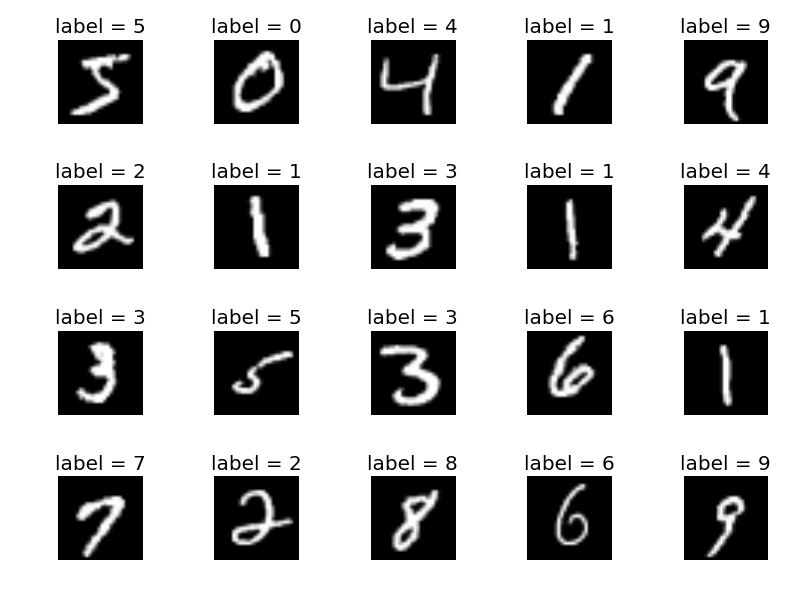

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 7500
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

### Adversary's goal: make some easy money 

In [24]:
from IPython.display import HTML
HTML('<img src="../utils/data/images/zero_to_one.png" width=400>')

In [3]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return add_pattern_bd(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return add_single_bd(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [4]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    # sources=np.arange(10) # 0, 1, 2, 3, ...
    # targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [5]:
# Poison training data
percent_poison = .33
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]


# Victim bank trains a neural network

In [6]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [7]:
classifier = KerasClassifier(model=model, clip_values=(min_, max_))
classifier.fit(x_train, y_train, nb_epochs=3, batch_size=128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/3
61/61 [==============================] - 8s 132ms/step - loss: 0.8180 - acc: 0.7331
Epoch 2/3
61/61 [==============================] - 7s 115ms/step - loss: 0.2557 - acc: 0.9264
Epoch 3/3
61/61 [==============================] - 7s 116ms/step - loss: 0.1681 - acc: 0.9539


# The victim bank evaluates the model

### Evaluation on clean test samples


Clean test set accuracy: 96.47%


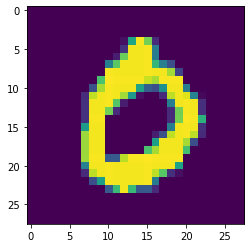

Prediction: 0


In [8]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(clean_y_test,1) == c)[0][i] # index of the image in clean arrays

plt.imshow(clean_x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

### But the adversary has other plans...

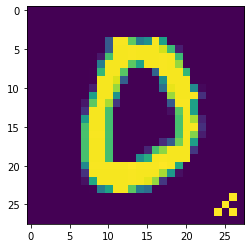

Prediction: 1

 Effectiveness of poison: 100.00%


In [9]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


### Evaluate accuracy on entire test set

In [10]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy: %.2f%%" % (total_acc * 100))


 Overall test set accuracy: 96.66%


<!-- # Detect Poison Using Activation Defence -->
<!-- ![image.png](attachment:image.png) -->

In [11]:
cleanse = NeuralCleanse(classifier)
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)

### Identifying the Backdoor

Unlike most defenses, part of the procedure for this defense is identifying exactly what the suspected backdoor is for each class. Below is the reverse-engineered backdoor. This will be appended to clean images to mimic backdoor behavior

Generating backdoor for class 1: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


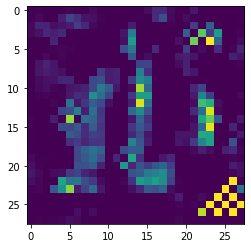

In [12]:
pattern, mask = defence_cleanse.generate_backdoor(x_test, y_test, np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))
plt.imshow(np.squeeze(mask * pattern))

Usually `generate_backdoor` is called as a result of calling `mitigate`. During this process, this defense generates a suspected backdoor for each class visualized above. The `mitigate` method also performs the mitigation  types presented below.

# Mitigation Types

There are different mitigation methods that are described below.

### Filtering

Filtering is the process of abstaining from potentially poisonous predictions at runtime. When this method is set, neurons are ranked by their association with the backdoor, and when neural activations are higher than normal, the classifier abstains from predication (output is all zeros).

In [13]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["filtering"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:11<00:00,  7.17s/it]


In [14]:
poison_pred = defence_cleanse.predict(poison_x_test)
num_filtered = np.sum(np.all(poison_pred == np.zeros(10), axis=1))
num_poison = len(poison_pred)
effectiveness = float(num_filtered) / num_poison * 100
print("Filtered {}/{} poison samples ({:.2f}% effective)".format(num_filtered, num_poison, effectiveness))

Filtered 500/559 poison samples (89.45% effective)


### Unlearning

Unlearning is the process of retraining the backdoors with the correct label for one epoch. This works best for Trojan-style triggers that react to a specific neuron configuration.

In [15]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["unlearning"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:10<00:00,  7.01s/it]

Epoch 1/1
   5/4129 [..............................] - ETA: 1:03 - loss: 2.7731 - acc: 0.6000    

4129/4129 [==============================] - 70s 17ms/step - loss: 0.0115 - acc: 0.9981


In [16]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after unlearning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after unlearning: 5.19% (previously 100.00%)

 Clean test set accuracy: 54.14% (previously 96.47%)


### Pruning

Pruning is the process of zero-ing out neurons strongly associated with backdoor behavior until the backdoor is ineffective or 30% of all neurons have been pruned. Be careful as this can negatively affect the accuracy of your model. This works best for fully mitigating the effects of backdoor poisoning attacks.

In [17]:
defence_cleanse = cleanse(classifier, steps=10, learning_rate=0.1)
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


In [19]:
poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]
new_poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison after pruning: %.2f%% (previously %.2f%%)" % (new_poison_acc * 100, poison_acc * 100))
clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

new_clean_acc = clean_correct / clean_total
print("\n Clean test set accuracy: %.2f%% (previously %.2f%%)" % (new_clean_acc * 100, clean_acc * 100))


 Effectiveness of poison after pruning: 0.00% (previously 100.00%)

 Clean test set accuracy: 46.46% (previously 96.47%)


### Combination

Finally, you can also do a combination of any of the above mitigation methods to fit your needs. Just add those types to the `mitigation_types` list.

In [20]:
defence_cleanse.mitigate(clean_x_test, clean_y_test, mitigation_types=["pruning", "filtering"])

Generating backdoor for class 9: 100%|██████████| 10/10 [01:10<00:00,  7.09s/it]
